In [7]:
import numpy as np
import random as rnd
import os
import re
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [8]:
languages = ['nodejs', 'java', 'go', 'posix', 'arduino_due']
log_modes = ['monitor', 'monitor-bin', 'monitor-bin_string']
modes = ['no', 'off', 'on']
fig_counter = 0
root='../../../src-gen/logs'

In [9]:
def allFiles(language, mode, log_mode):
    directory = os.fsencode(root + '/' + log_mode + '/' + mode)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.split('-')[1] == language and filename.endswith('.log'): 
            yield root + '/' + log_mode + '/' + mode + '/' + filename
            
def loadMemory(filename, language):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break
        if '>usedMem:' in line:
            mem = int(line[1:].strip().split(':')[1:][0])
            yield mem   
            
def loadTotalTime(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break                  
        if '>done in ' in line:
            time = int(line.split('>')[1][8:-4])
            return time

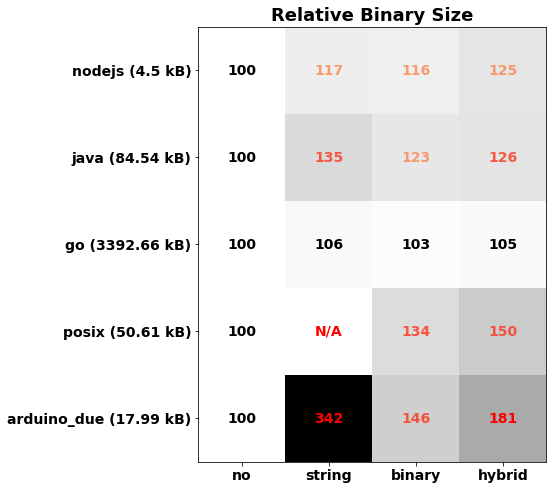

In [23]:
def allData(language, mode, log_mode):
    all_mem = []
    all_t = []
    for filename in allFiles(language, mode, log_mode):
        mem = np.array(list(loadMemory(filename, language))).astype(int).flatten()
        t = loadTotalTime(filename)
        all_mem.append(mem)
        all_t.append(t)
    return all_mem, all_t

def allStaticData(language):
    all_bin = []
    file = open(root + '/log.cloc')
    while True:
        line = file.readline()      
        if not line:
            break                  
        if language in line:            
            bin = 0
            if ':bin:' in line:
                try:
                    bin = int(line.split(':bin:')[1])
                except:
                    bin = 0
                all_bin.append(bin)            
    return all_bin

all_bin = []
y_bin = []
for language in languages:
    bin = allStaticData(language)    
    all_bin.append(np.round(np.array(bin)/bin[0]*100,0))
    y_bin.append(language + ' (' + str(np.round(bin[0]/1000,2)) + ' kB)')

all_bin[3][1] = 100 #set posix string to 100 to avoid perturbating the colormap with 0
    
fig = plt.figure(fig_counter, figsize=(10,8))        
plt.imshow(all_bin, cmap='binary')
plt.xticks(range(0, 4), ('no', 'string', 'binary', 'hybrid'), weight='heavy', fontsize=14)
plt.yticks(range(0, 5), y_bin, weight='heavy', fontsize=14)
for x_val in range(0, 4):
    for y_val in range(0, len(languages)):        
        if x_val == 1 and y_val == 3:
            c = 'N/A'
            plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14, color = 'r')
        else:
            c = int(all_bin[y_val][x_val])
            color = color=(0,0,0,1)
            if c > 150:
                color=(1,0,0,1)
            elif c > 125:
                color=(1,0.2,0.1,0.8)
            elif c > 110:
                color=(1,0.4,0.1,0.6)
            plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14, color=color)        
        
        
plt.title('Relative Binary Size', weight='heavy', fontsize=18)
plt.show()  
fig_counter = fig_counter + 1   

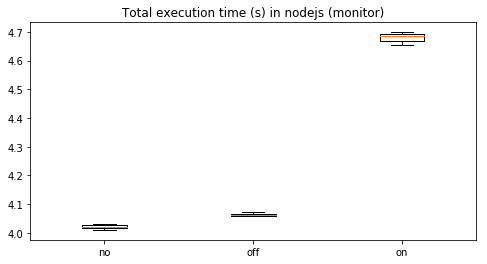

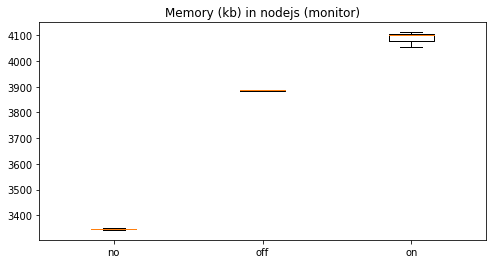

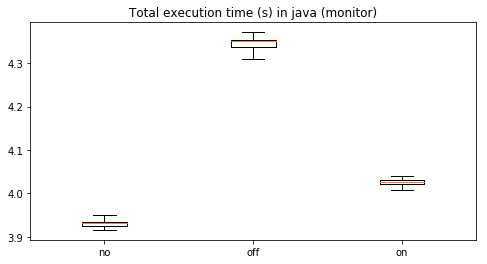

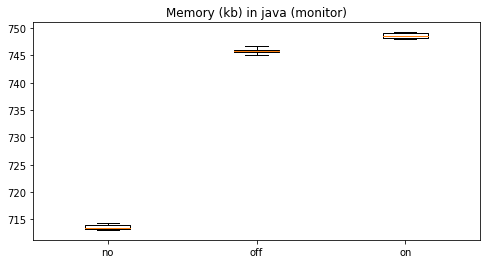

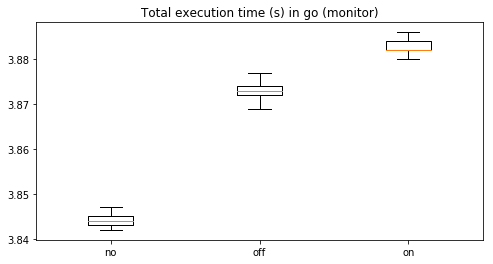

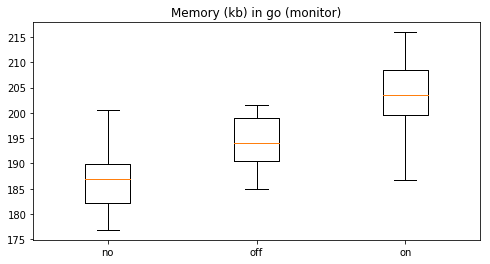

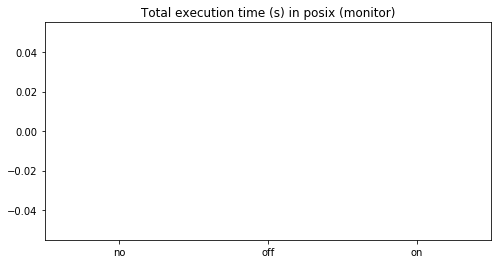

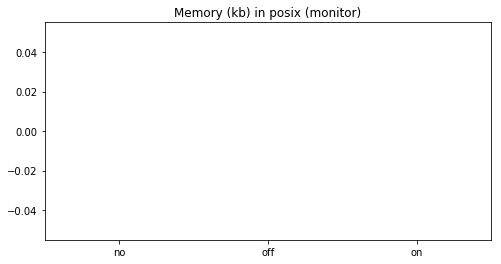

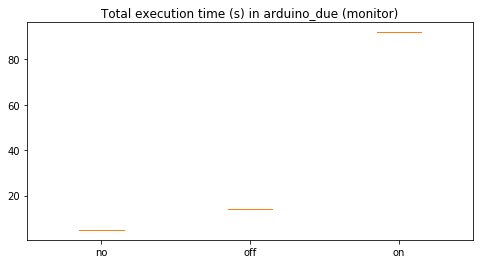

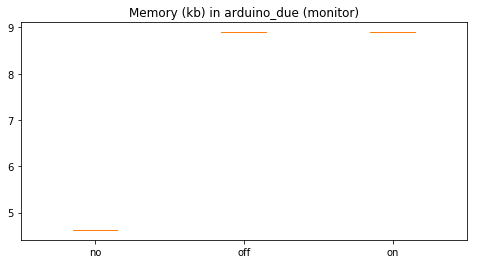

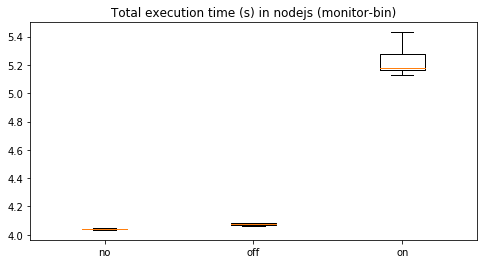

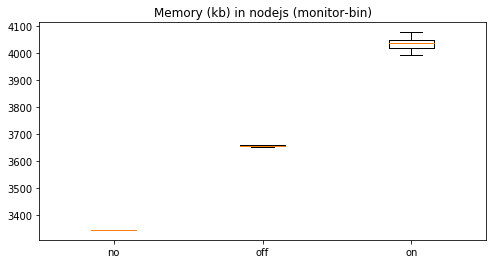

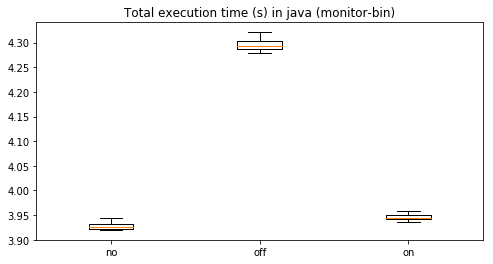

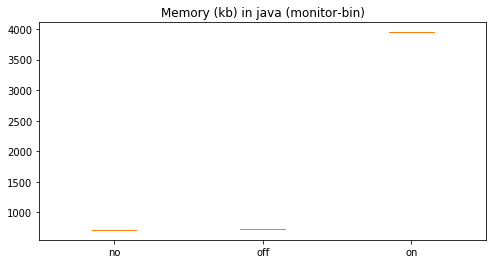

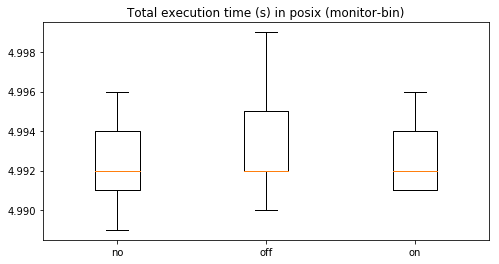

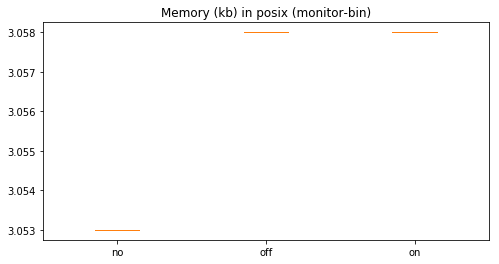

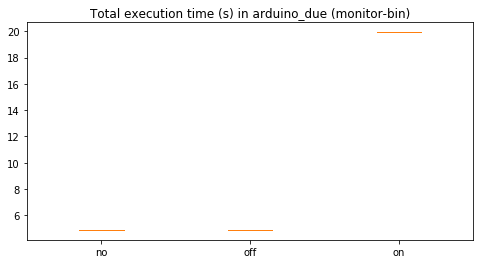

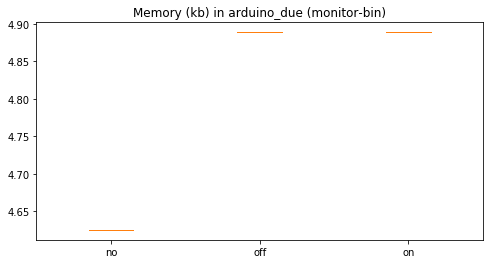

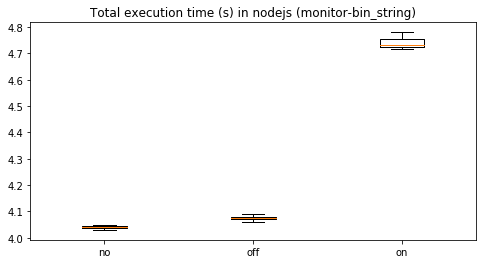

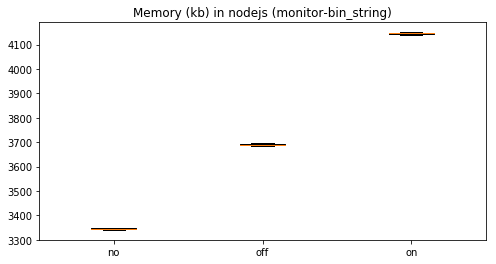

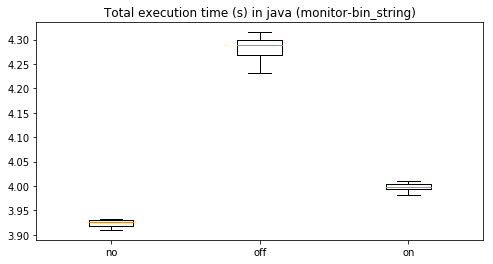

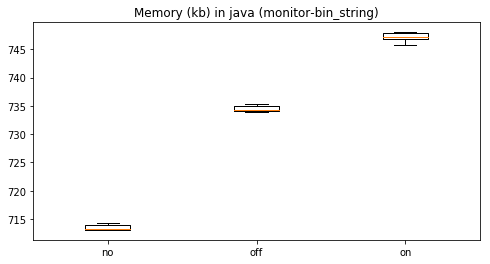

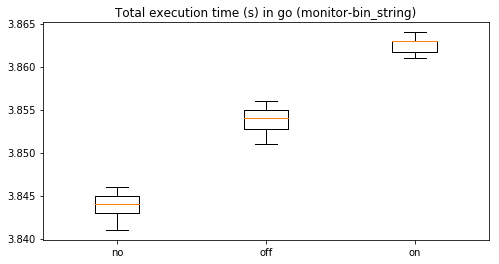

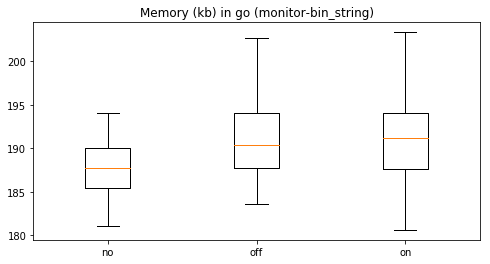

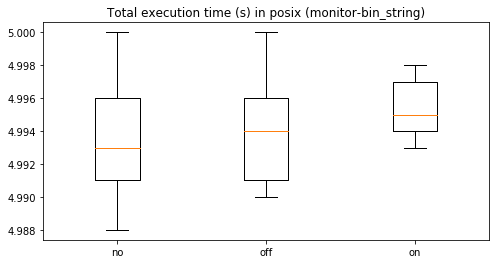

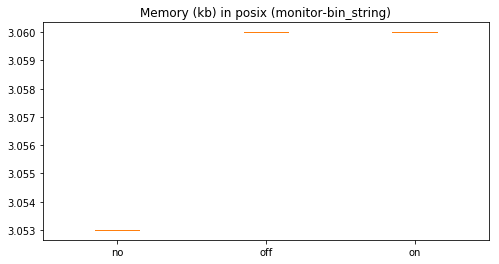

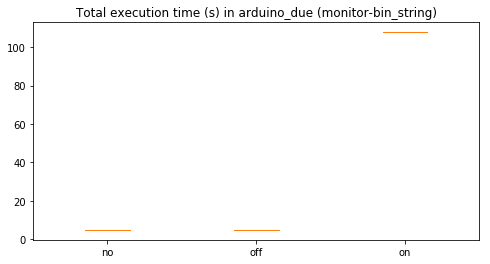

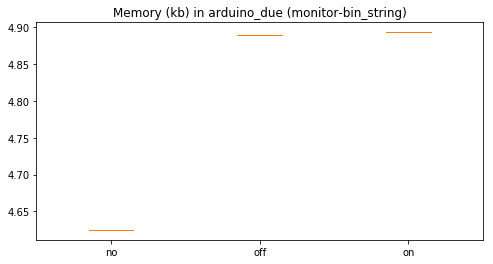

In [11]:
for log_mode in log_modes:
    global fig_counter
    for language in languages:            
        all_t = []
        all_mem = []
        hasError = False
        for mode in modes:
            try:
                mem, t = allData(language, mode, log_mode)
                all_t.append(np.array(t).flatten()/1000)
                all_mem.append(np.array(mem).flatten()/1000)
            except TypeError:
                hasError = True
                break
        
        if hasError:
            continue
            
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_t, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Total execution time (s) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_mem, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Memory (kb) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


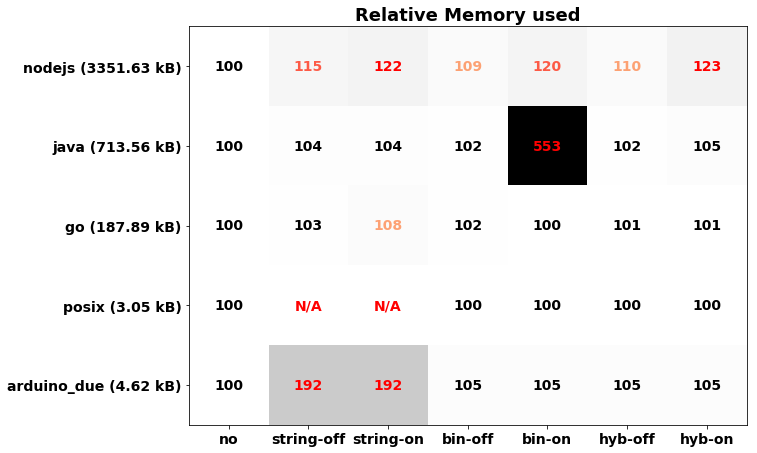

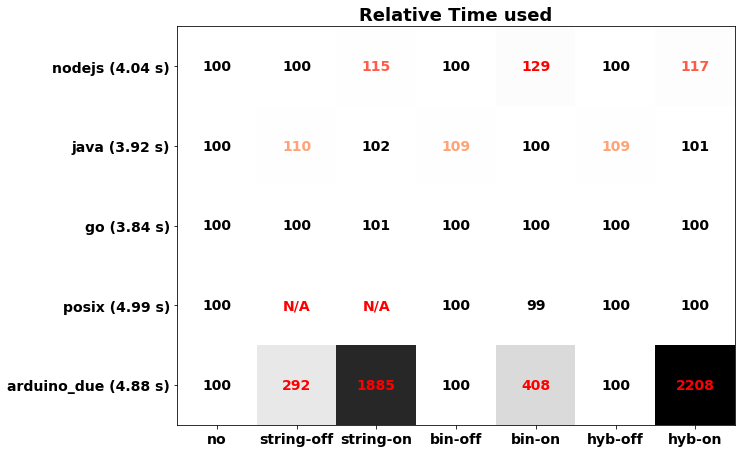

In [14]:
def mem_t_by_language(language, mode, log_mode):
    mem, t = allData(language, mode, log_mode)
    return np.mean(mem), np.mean(t)    

all_t = []
all_mem = []
valid_lang_mem = []
valid_lang_t = []
for language in languages:    
    lang_t = []
    lang_mem = []
    mem_no, t_no = mem_t_by_language(language, 'no', log_mode)    
    lang_t.append(t_no)
    lang_mem.append(mem_no)    
    for log_mode in log_modes:
        for mode in modes:
            if 'no' == mode:
                continue
            try:                
                mem, t = mem_t_by_language(language, mode, log_mode)
                if np.isnan(mem):
                    mem = mem_no
                if np.isnan(t):
                    t = t_no               
            except TypeError:
                mem = mem_no
                t = t_no
            lang_t.append(t)
            lang_mem.append(mem)
    valid_lang_mem.append(language + ' (' + str(round(mem_no/1000,2)) + ' kB)')
    valid_lang_t.append(language + ' (' + str(round(t_no/1000,2)) + ' s)')
    lang_t = np.round(np.array(lang_t)/t_no*100,2)
    lang_mem = np.round(np.array(lang_mem)/mem_no*100,2)
    all_t.append(lang_t)        
    all_mem.append(lang_mem)        

# print(np.array(all_t).shape)
# print(np.array(all_t))
# print(np.array(all_mem).shape)
# print(np.array(all_mem))

#Arduino serial baud rate is set to 220000 i.e. 27500 kB/s
#this means, 97.13s is spent on the serial port in bin_string mode
#this means, 
    
def plotSummary(array, legend, ylegend):
    global fig_counter
    fig = plt.figure(fig_counter, figsize=(10,8))        
    plt.imshow(array, cmap='binary')#'OrRd')
    plt.xticks(range(0, 7), ('no', 'string-off', 'string-on', 'bin-off', 'bin-on', 'hyb-off', 'hyb-on'), weight='heavy', fontsize=14)
    plt.yticks(range(0, len(ylegend)), ylegend, weight='heavy', fontsize=14)
    for x_val in range(0, 7):
        for y_val in range(0, len(ylegend)):        
            if (x_val == 1 or x_val == 2) and y_val == 3:
                c = 'N/A'
                plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14, color = 'r')
            else:
                c = int(array[y_val][x_val])
                color = color=(0,0,0,1)
                if c > 120:
                    color=(1,0,0,1)
                elif c > 110:
                    color=(1,0.2,0.1,0.8)
                elif c > 105:
                    color=(1,0.4,0.1,0.6)
                plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14, color=color)
        
    plt.title(legend, weight='heavy', fontsize=18)
    plt.show()  
    fig_counter = fig_counter + 1
    
plotSummary(all_mem, 'Relative Memory used', valid_lang_mem)
plotSummary(all_t, 'Relative Time used', valid_lang_t)